In [230]:
import os
import sys
from pathlib import Path

import anndata as ad
import cv2 as cv
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.pyplot import rc_context
from skimage import exposure, io
from skimage.util import img_as_ubyte
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange
from matplotlib.patches import Patch

sc.settings.verbosity = 3

In [231]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [232]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

import scanorama
import utils as my_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [233]:
experiment = "endometrium"
cores = ["L128"]
datasets = ["L11_2", "L11_3"]+[core + f"_{i}" for core in cores for i in range(1, 4)]

# Load data

In [234]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [235]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [236]:
adatas = []
df_sums = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    data_all = df_intensity_TS.iloc[:, 1:].values
    # data_all_norm = (data_all+0.1)/(np.percentile(data_all,50,axis=1,keepdims=True)+0.1)
    # data_all_norm = MinMaxScaler().fit_transform(data_all)
    # df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    df_sums.append(df.sum(axis=0))
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    adatas.append(adata)
adata = ad.concat(adatas, join="inner")

Sucessfully read dataset L11_2
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset L11_3
normalizing counts per cell
    finished (0:00:00)


C:\Users\thu71\AppData\Local\Temp/ipykernel_14276/1887427505.py:28: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(df.values)


Sucessfully read dataset L128_1
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset L128_2
normalizing counts per cell
    finished (0:00:00)
Sucessfully read dataset L128_3
normalizing counts per cell
    finished ({time_passed})


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [237]:
df_sum = pd.concat(df_sums, axis=1).mean(axis=1)
mz_qc = df_sum[(df_sum > 40000)].index.tolist()

In [238]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}.h5ad"
adata_IMC_cluster = ad.read_h5ad(path)


In [239]:
df_sum = pd.concat(df_sums, axis=1).mean(axis=1)
mz_qc = df_sum[(df_sum > 41000)].index.tolist()

In [240]:
len(mz_qc)

167

In [241]:
adata = adata[:, mz_qc]

## Get literature lut

In [242]:
SIMS_masses = adata.var_names

In [243]:
# Read litterature lut
file_path = data_dir / "metadata" / 'Putative_annotation_09012022.xlsx'
df = pd.read_excel(file_path)
lum = df['m/z'].to_numpy()

# get matched table by looking at difference with error
error = 0.4
matched_dfs = []
for mz in SIMS_masses.astype(float):
    if mz < 1.1:
        continue
    diff = lum-mz
    matched = df[abs(diff)<error]
    if len(matched) > 0:
        matched.loc[:,'SIMS mz'] = mz
        matched_dfs.append(matched)
    else:
        matched = pd.DataFrame([['', '', '', '', mz]], columns=df.columns.tolist() + ['SIMS mz'])
        matched_dfs.append(matched)
matched = pd.concat(matched_dfs)

C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [244]:
# Get all info from litterature excel
SIMS_masses_subset = np.array(matched['SIMS mz'].to_list(), dtype=float).astype(str)
SIMS_masses_subset = pd.Index(SIMS_masses_subset)

SIMS_name_subset = np.array(matched['Molecules'].to_list()).astype(str)
SIMS_name_subset = pd.Index(SIMS_name_subset)

SIMS_nm_subset = SIMS_masses_subset + 'm/z ' + SIMS_name_subset

SIMS_type_subset = np.array(matched['Type'].to_list()).astype(str)
SIMS_type_subset = pd.Index(SIMS_type_subset)

print(f"Number of matched m/z: {len(SIMS_masses_subset)}")

Number of matched m/z: 167


In [245]:
adata_all = adata.copy()
adata = adata[:, SIMS_masses_subset]
adata.var_names = SIMS_nm_subset

# Rename clusters

In [246]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [247]:
type_dict = {'0': 'Other',
            '1': 'Epithelial',
            '2': 'Vimentin+', 
            '3': 'CD3+CD8+',
            }

In [248]:
adata_CN = adata_IMC_cluster.copy()

In [249]:
adata_CN.obs['Type'] = (
    adata_CN.obs['leiden']
    .map(type_dict)
    .astype("category")
)
adata_CN.uns['Type_colors'] = adata_CN.uns['leiden_colors'][:len(np.unique(adata_CN.obs['Type']))]

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Type']`


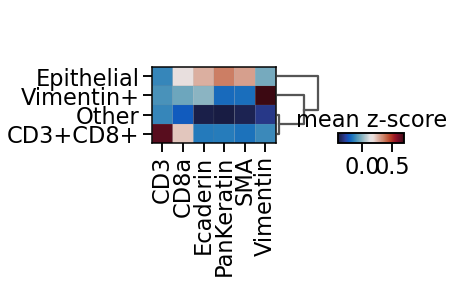

In [250]:
sc.tl.dendrogram(adata_CN, groupby='Type')

sc.pl.matrixplot(
    adata_CN,
    adata_CN.var_names.tolist(),
    "Type",
    dendrogram=True,
    colorbar_title="mean z-score",
    cmap=heatmap_cmp,
    swap_axes=False,
    # vmin=-0.25,
    # vmax=0.5
)

In [251]:
cluster_label_order = adata_CN.uns['dendrogram_Type']['categories_ordered']

In [252]:
import matplotlib 

colors = adata_CN.uns["Type_colors"]
labels = adata_CN.obs.Type.cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

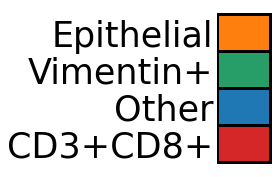

In [253]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,3))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


# Plot cluster masks

In [254]:
from typing import List
import matplotlib
import skimage
from skimage import measure


def get_masks(mask_folder, dataset):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name and dataset in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


def create_clustered_cell(mask, label2cell, my_cmap, **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)

    for i, cells in tqdm(label2cell.items(), total=len(label2cell)):
        rows, cols = np.where(np.isin(mask, cells))
        img[rows, cols, :] = my_cmap[int(i)]

    return img


def get_contour(mask: np.ndarray) -> List[List[float]]:
    """
    Get contours of mask
    """
    contours = []
    for i in sorted(np.unique(mask)):
        if i == 0:
            continue
        contours.append(measure.find_contours(mask == i, 0.8)[0])

    return contours

In [255]:
experiment='endometrium'

In [256]:
masks = get_masks(data_dir / "masks", f"{experiment}")

In [257]:
group = 'Type'

colors = adata_CN.uns[f"{group}_colors"]
labels = np.unique(adata_CN.obs[group].tolist())

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

  0%|          | 0/4 [00:00<?, ?it/s]

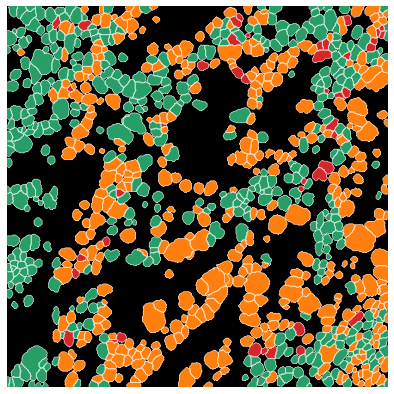

  0%|          | 0/4 [00:00<?, ?it/s]

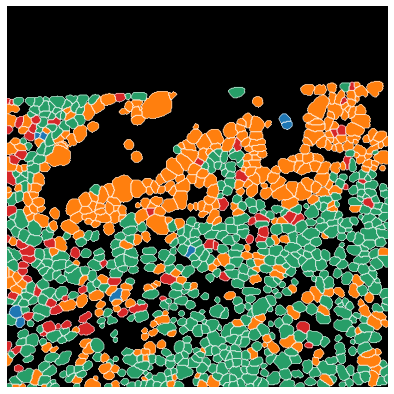

  0%|          | 0/4 [00:00<?, ?it/s]

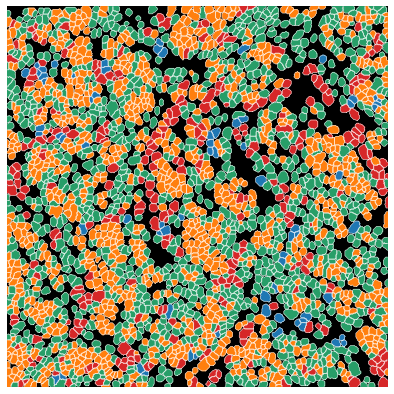

  0%|          | 0/4 [00:00<?, ?it/s]

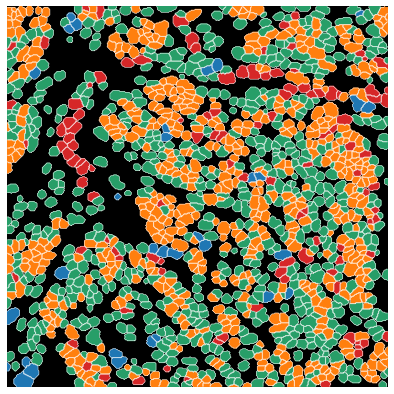

  0%|          | 0/4 [00:00<?, ?it/s]

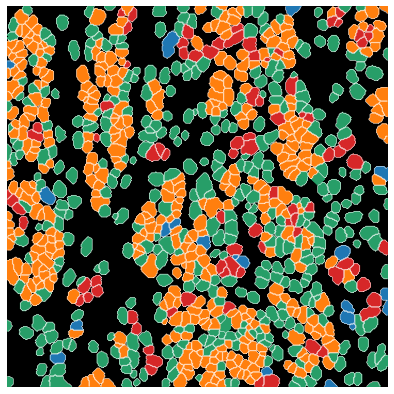

In [258]:
for dataset in adata_CN.obs['Core'].unique():
    adata_fov = adata_CN[adata_CN.obs['Core'] == dataset]
    try:
        mask = masks["_".join([experiment, dataset])]
        contours = get_contour(mask)
    except:
        print(dataset)
        continue
     # Get label2cell dict
    
    label2cell = {}
    for i, l in enumerate(labels):
        cell_id = adata_fov[adata_fov.obs[group] == l].obs.Cell.to_list()
        label2cell[i] = cell_id

    img = create_clustered_cell(mask, label2cell, colors_rgb)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(img)
    for j, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="white")
    ax.axis("off")
    plt.show()


# Stats

In [259]:
df_test = pd.DataFrame()
df_test["Dataset"] = adata_CN.obs["Core"].tolist()
df_test["Type"] = adata_CN.obs["Type"].tolist()

In [260]:
clusters = df_test["Type"].unique().tolist()

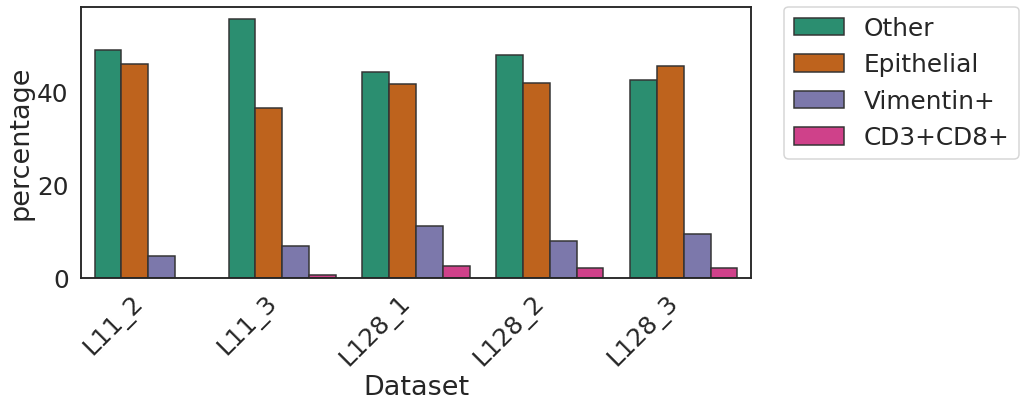

In [261]:
df_test_grouped = (
    df_test.groupby("Dataset")["Type"]
    .value_counts(normalize=True)
    .rename("percentage")
    .mul(100)
    .reset_index()
)

with sns.axes_style("white"):
    sns.barplot(
        data=df_test_grouped,
        x="Dataset",
        y="percentage",
        hue="Type",
        palette="Dark2",
        edgecolor=".2"
    )
    plt.gcf().set_size_inches(12, 5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.xticks(rotation=45, ha='right')


# SIMS comparison

In [262]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [263]:
adata.obs["Type"] = adata_CN.obs["Type"]
adata.uns["Type_colors"] = adata_CN.uns["Type_colors"]
adata.obsm["spatial"] = adata_CN.obsm["spatial"]

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Type']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


C:\Users\thu71\Anaconda3\envs\new_codex\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


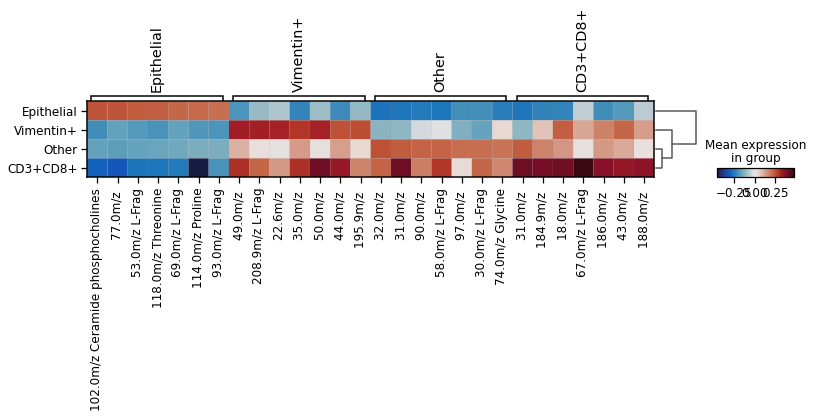

In [264]:
sc.tl.dendrogram(adata, groupby='Type')
sc.tl.rank_genes_groups(adata, groupby='Type', method='t-test_overestim_var')

with sns.plotting_context('notebook', font_scale=1.2):
    sc.pl.rank_genes_groups_matrixplot(adata, n_genes=7, use_raw=False, cmap=heatmap_cmp)

In [265]:
# Extract diff expression dataframe
dedf = sc.get.rank_genes_groups_df(adata, group=None)

# Get top diff expression
topk=5
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
masses = np.unique(np.concatenate([masses_largest, masses_lowest]))

In [266]:
masses

array(['102.0m/z Ceramide phosphocholines', '114.0m/z Proline',
       '118.0m/z Threonine', '16.0m/z ', '18.0m/z ', '184.9m/z ',
       '186.0m/z ', '208.9m/z L-Frag', '22.6m/z ', '31.0m/z ', '32.0m/z ',
       '34.0m/z ', '35.0m/z ', '40.0m/z ', '49.0m/z ', '50.0m/z ',
       '53.0m/z L-Frag', '54.0m/z L-Frag', '55.0m/z L-Frag',
       '56.0m/z L-Frag', '58.0m/z L-Frag', '65.0m/z L-Frag',
       '67.0m/z L-Frag', '69.0m/z L-Frag', '77.0m/z ', '78.0m/z ',
       '80.0m/z L-Frag', '81.0m/z L-Frag', '90.0m/z ', '97.0m/z '],
      dtype=object)

In [267]:
# Extract dataframe
var = 'Type'

adata_subset = adata[:,masses]
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()

df_SIMS_grouped = df_SIMS.groupby([var]).mean()

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Type']`


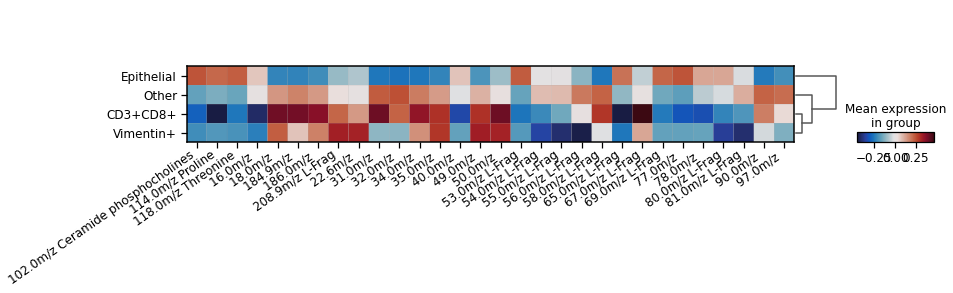

In [268]:
adata_grouped = ad.AnnData(df_SIMS_grouped.values)
adata_grouped.var_names = df_SIMS_grouped.columns.tolist()
adata_grouped.obs['Type'] = df_SIMS_grouped.index.tolist()
adata_grouped.obs['Type'] = adata_grouped.obs['Type'].astype('category')

sc.tl.dendrogram(adata_grouped, groupby='Type')
with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.matrixplot(adata_grouped, 
                     var_names=adata_grouped.var_names, 
                     groupby='Type',
                     cmap=heatmap_cmp,
                     dendrogram=True,
                     show=False
                    )
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

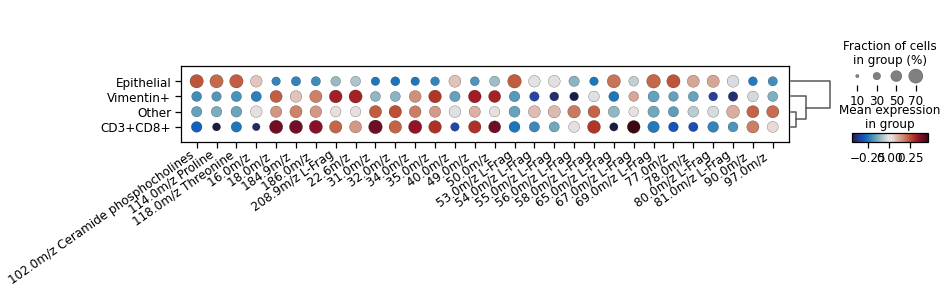

In [269]:
with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.dotplot(adata, var_names=masses, groupby='Type',
                    cmap=heatmap_cmp, dendrogram=True, show=False)
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

In [270]:
# Get top diff expression
topk=3
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
masses = np.unique(np.concatenate([masses_largest, masses_lowest]))

In [271]:
# Get subset of masses
adata_subset = adata[:,masses]

# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
# df_SIMS.drop(['1.0'], axis=1, inplace=True)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))
df = df_SIMS_var[df_SIMS_var[var] == 'Epithelial'].groupby('mz').mean()
df.sort_values('Normalized ion count', inplace=True)
masses_sorted = df.index.tolist()

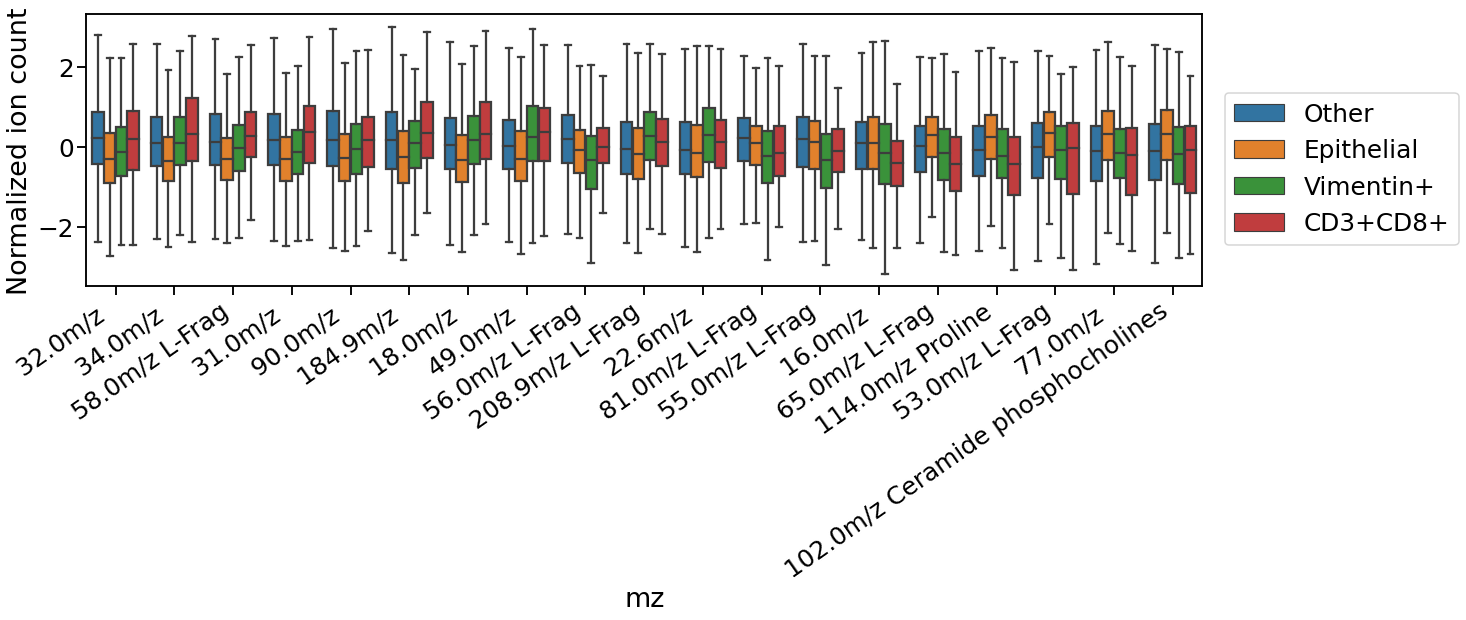

In [272]:
sns.set_context('talk', font_scale=1.5)

fig, ax = plt.subplots(figsize=(20,5))
sns.boxplot(data=df_SIMS_var, 
            hue=var, 
            x='mz', 
            y='Normalized ion count',
            order=masses_sorted,
            ax=ax, 
            palette='tab10', 
            showfliers=False)
plt.xticks(rotation = 35, ha='right')
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)


### Plot by mz channel

In [273]:
import palettable
h5_data_dir = p_dir / "data" / "h5"
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap

from typing import List
import matplotlib
import skimage
from skimage import measure

h5_data_dir = p_dir / "data" / "h5"

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


def create_clustered_cell(mask, cell2count,  **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1]))*np.nan

    for cell, counts in tqdm(cell2count.items(), total=len(cell2count)):
        rows, cols = np.where(np.isin(mask, cell))
        img[rows, cols] = counts

    return img

def get_contour(mask: np.ndarray) -> List[List[float]]:
    """
    Get contours of mask
    """
    contours = []
    for i in sorted(np.unique(mask)):
        if i == 0:
            continue
        contours.append(measure.find_contours(mask == i, 0.8)[0])

    return contours

def get_imgs_sims(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
    return imgs[2:], labels[2:]

def IMS(imgs, mz, masses):
    mz_img = imgs[np.equal(masses, mz),...][0]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(mz_img, cmap='rainbow', interpolation='quadric', vmin=0, vmax=np.percentile(mz_img, 90))  
    ax.axis('off')
    plt.title(f'{mz} m/z')
    plt.show()
    return mz_img 

def get_imgs_sims(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
    return imgs[2:], labels[2:]

def IMS(imgs, mz, masses):
    mz_img = imgs[np.equal(masses, mz),...][0]
    # fig, ax = plt.subplots(figsize=(7,7))
    # ax.imshow(mz_img, cmap=heatmap_cmp, interpolation='quadric', vmin=0,vmax=np.percentile(mz_img, 99))  
    # ax.axis('off')
    # plt.title(f'{mz} m/z')
    # plt.show()
    return mz_img 

In [274]:
masks = get_masks(data_dir / "masks")
experiment='endometrium'

  0%|          | 0/1414 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

  0%|          | 0/1414 [00:00<?, ?it/s]

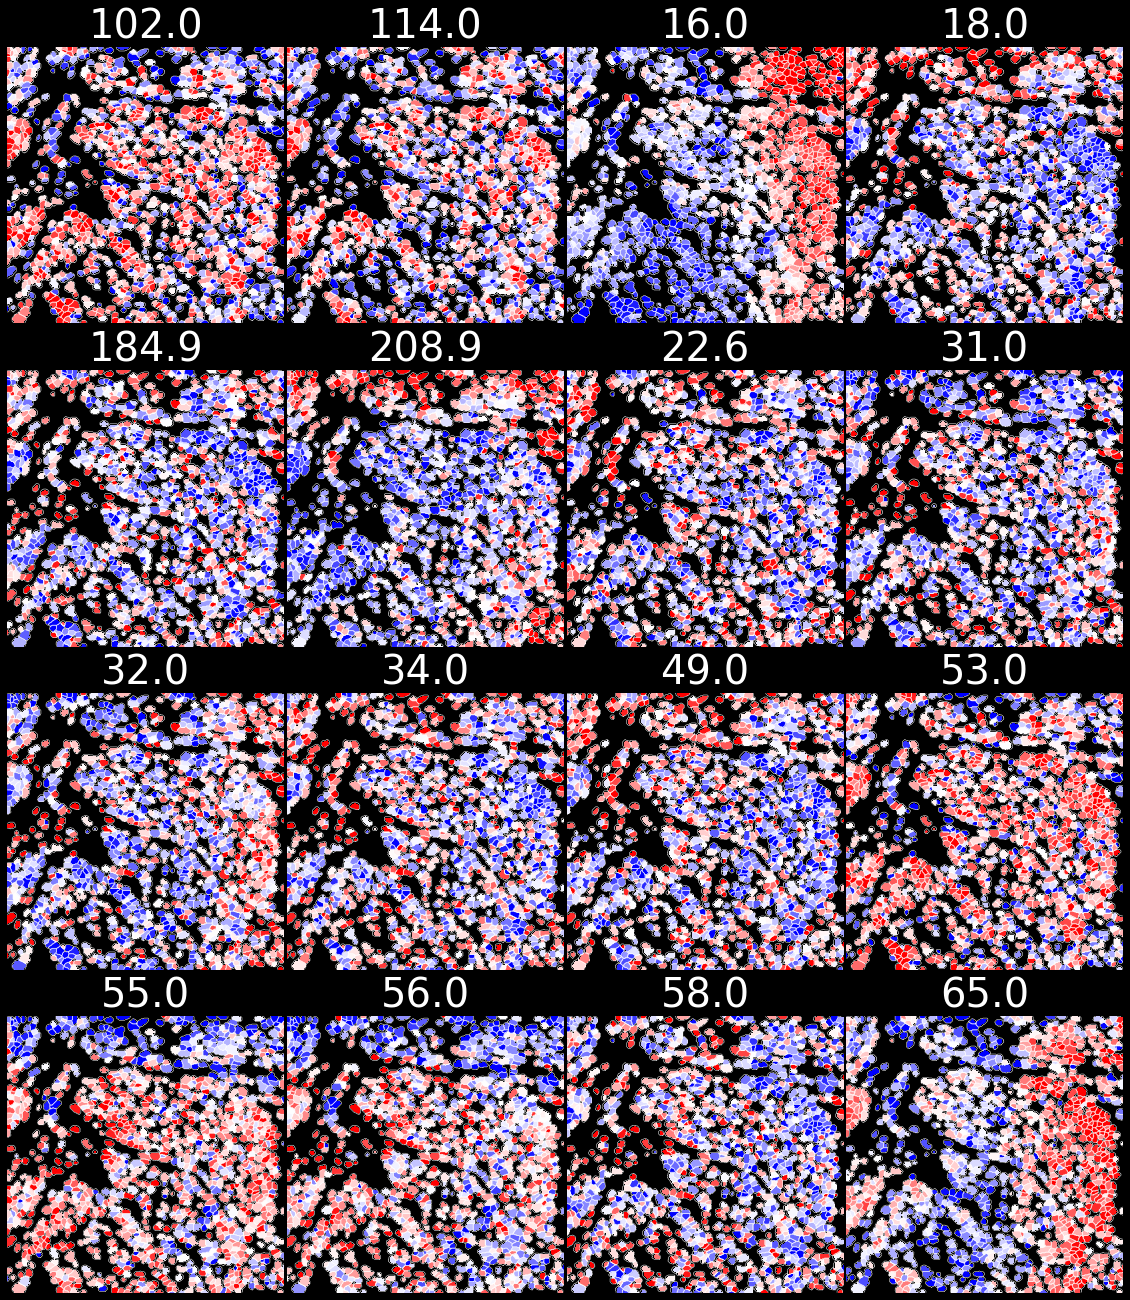

In [278]:
dataset = 'L128_2'

mask = masks[experiment + '_' + dataset]
contours = get_contour(mask)

adata_fov = adata[adata.obs['Dataset'] == dataset]

fig, axs = plt.subplots(4,4,figsize=(20, 23), facecolor='k')
axs = axs.flatten()
for i, channel in enumerate(masses[:16]):
    ax = axs[i]
    
    adata_subset = adata_fov[:, channel]
    # Get label2cell dict
    cells = adata_subset.obs['Cell'].to_list()
    counts = adata_subset.X.flatten()
    cell2count = dict(zip(cells, counts))

    img = create_clustered_cell(mask, cell2count)

    ax.imshow(img, cmap='bwr', vmin=np.nanpercentile(img, 5), vmax=np.nanpercentile(img, 95))
    ax.set_title(f"{channel.split('m/z')[0]}", size=40, c='w')
    for j, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="white")
    ax.axis("off")
fig.subplots_adjust(wspace=0.01, hspace=0.15)
plt.show()

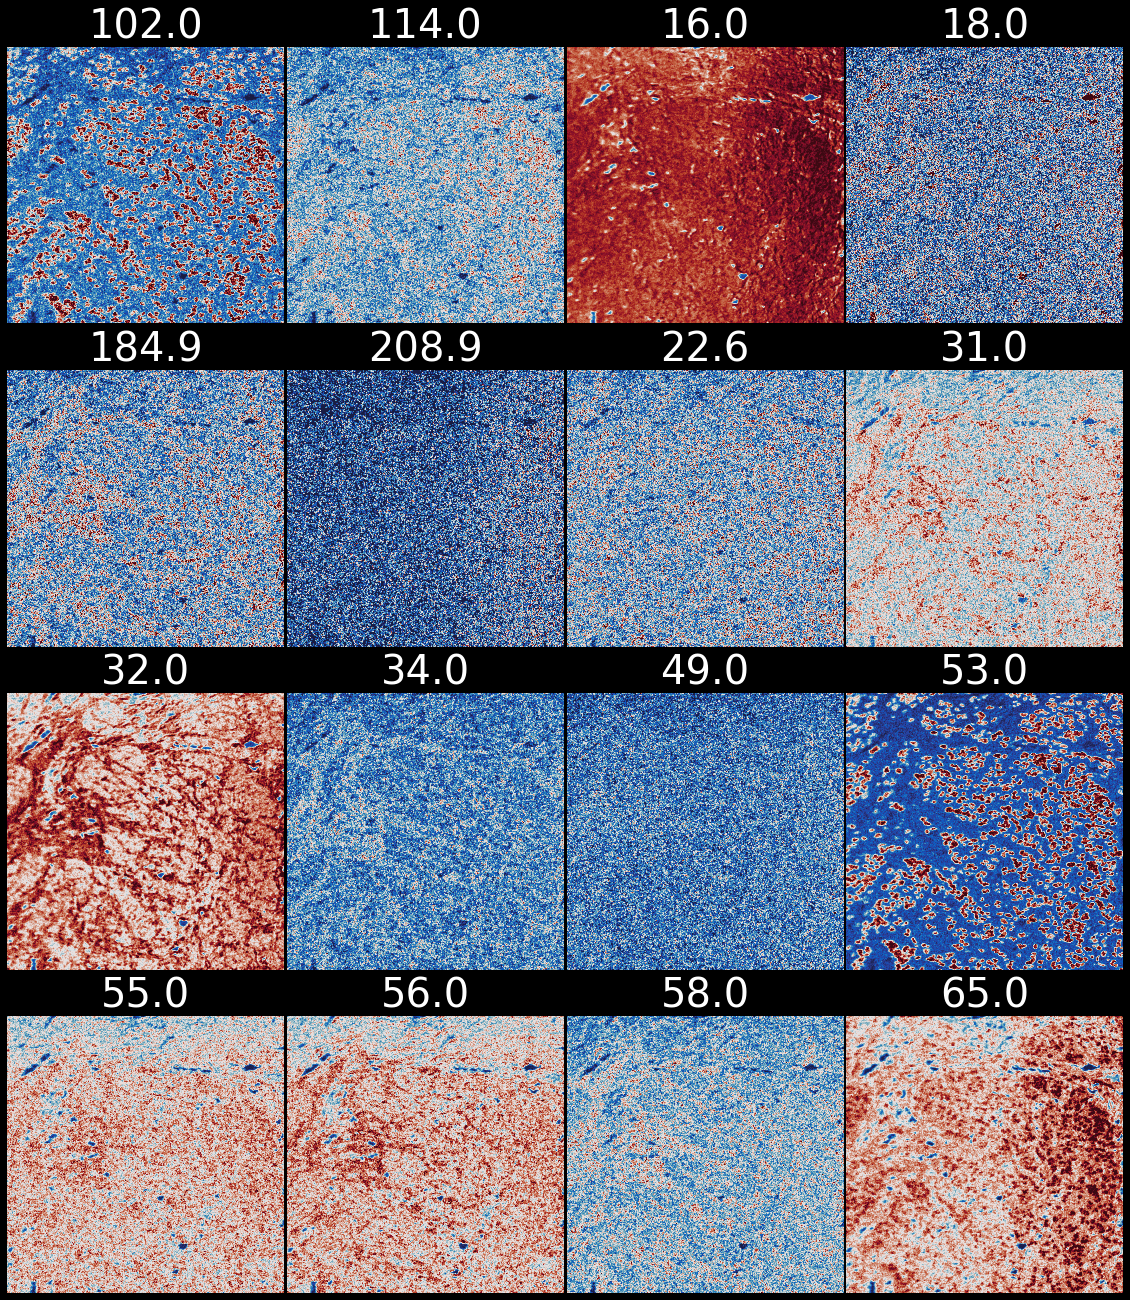

In [279]:
imgs, labels = get_imgs_sims(experiment, 'auto_'+dataset)
mzs = np.array(df_intensity_TS.columns.tolist()).astype(float)

fig, axs = plt.subplots(4,4,figsize=(20, 23), facecolor='k')
axs = axs.flatten()
for i, channel in enumerate(masses[:16]):
    ax = axs[i]
    
    mz = float(channel.split('m/z')[0])
    mz_img = IMS(imgs, mz, mzs)
    
    ax.imshow(mz_img, cmap=heatmap_cmp, interpolation=None, vmin=0, vmax=np.percentile(mz_img, 95))
    ax.set_title(mz, size=40, c='w')
    ax.axis("off")
fig.subplots_adjust(wspace=0.01, hspace=0.15)
plt.show()
